In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import sys
sys.path.append(os.path.abspath('..'))
from pos_baseline import get_data
from sklearn.utils import shuffle
from util import init_weight
from datetime import datetime
from sklearn.metrics import f1_score

from tensorflow.contrib.rnn import static_rnn as get_rnn_output
from tensorflow.contrib.rnn import BasicRNNCell, GRUCell

/Users/yuanjing/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_data(split_sequences = False):
    if not os.path.exists('chunking'):
        print("Please create a folder in your local directory called 'chunking'")
        print("train.txt and test.txt should be stored in there.")
        print("Please check the comments to get the download link.")
        exit()
    elif not os.path.exists('chunking/train.txt'):
        print("train.txt is not in chunking/train.txt")
        print("Please check the comments to get the download link.")
        exit()
    elif not os.path.exists('chunking/test.txt'):
        print("test.txt is not in chunking/test.txt")
        print("Please check the comments to get the download link.")
        exit()
    
    word2idx = {}
    tag2idx = {}
    word_idx = 1
    tag_idx = 1
    Xtrain = []
    Ytrain = []
    currentX = []
    currentY = []
    for line in open('chunking/train.txt'):
        line = line.rstrip()
        if line:
            r = line.split()
            word, tag, _ = r
            if word not in word2idx:
                word2idx[word] = word_idx
                word_idx += 1
            currentX.append(word2idx[word])
            
            if tag not in tag2idx:
                tag2idx[tag] = tag_idx
                tag_idx += 1
            currentY.append(tag2idx[tag])
        
        elif split_sequences:
            Xtrain.append(currentX)
            Ytrain.append(currentY)
            currentX = []
            currentY = []
    
    if not split_sequences:
        Xtrain = currentX
        Ytrain = currentY
    
    # load and score test data
    Xtest = []
    Ytest = []
    currentX = []
    currentY = []
    for line in open('chunking/test.txt'):
        line = line.rstrip()
        if line:
            r = line.split()
            word, tag, _ = r
            if word in word2idx:
                currentX.append(word2idx[word])
            else:
                currentX.append(word_idx)
            currentY.append(tag2idx[tag])
        
        elif split_sequences:
            Xtest.append(currentX)
            Ytest.append(currentY)
            currentX = []
            currentY = []
    if not split_sequences:
        Xtest = currentX
        Ytest = currentY
    
    return Xtrain, Ytrain, Xtest, Ytest, word2idx

In [3]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [4]:
# get the data
Xtrain, Ytrain, Xtest, Ytest, word2idx = get_data(split_sequences = True)
V = len(word2idx) + 2
K = len(set(flatten(Ytrain)) | set(flatten(Ytest))) + 1

In [5]:
# training config
epochs = 20
learning_rate = 1e-2
mu = 0.99
batch_size = 32
hidden_layer_size = 10
embedding_dim = 10
sequence_length = max(len(x) for x in Xtrain + Xtest) # 78

In [6]:
# pad sequences
Xtrain = tf.keras.preprocessing.sequence.pad_sequences(Xtrain, maxlen = sequence_length) # numpy array
Ytrain = tf.keras.preprocessing.sequence.pad_sequences(Ytrain, maxlen = sequence_length)
Xtest = tf.keras.preprocessing.sequence.pad_sequences(Xtest, maxlen = sequence_length)
Ytest = tf.keras.preprocessing.sequence.pad_sequences(Ytest, maxlen = sequence_length)
print("Xtrain.shape:", Xtrain.shape)
print("Ytrain.shape:", Ytrain.shape)

Xtrain.shape: (8936, 78)
Ytrain.shape: (8936, 78)


In [7]:
# inputs
inputs = tf.placeholder(tf.int32, shape = (None, sequence_length))
targets = tf.placeholder(tf.int32, shape = (None, sequence_length))
num_samples = tf.shape(inputs)[0]

# embedding
We = np.random.randn(V, embedding_dim).astype(np.float32)

# output layer
Wo = init_weight(hidden_layer_size, K).astype(np.float32)
bo = np.zeros(K).astype(np.float32)

# make tensorflow variables
tfWe = tf.Variable(We)
tfWo = tf.Variable(Wo)
tfbo = tf.Variable(bo)

rnn_unit = GRUCell(num_units = hidden_layer_size, activation = tf.nn.relu)

# get the output
x = tf.nn.embedding_lookup(tfWe, inputs) # shape: N x T x D

# convert x from tensor of size NxTxD 
# into list of length T, with each element a tensor of shape NxD
x = tf.unstack(x, sequence_length, 1)

# rnn output
outputs, states = get_rnn_output(rnn_unit, x, dtype = tf.float32)

# outputs: T x N x M
# make it (N, T, M)
outputs = tf.transpose(outputs, (1, 0, 2))
outputs = tf.reshape(outputs, (sequence_length*num_samples, hidden_layer_size)) # NT x M

# final dense layer
logits = tf.matmul(outputs, tfWo) + tfbo # NT x K
predictions = tf.argmax(logits, 1)
predict_op = tf.reshape(predictions, (num_samples, sequence_length))
labels_flat = tf.reshape(targets, [-1]) # flatten to 1-D tensor

cost_op = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits = logits,
        labels = labels_flat
    )
)
train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost_op)


In [8]:
# init stuff
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

i: 0 cost: 172.5766 train acc: 0.5360 test acc: 0.7765 time for epoch: 0:00:08.134658
i: 1 cost: 47.8917 train acc: 0.8553 test acc: 0.8745 time for epoch: 0:00:07.408661
i: 2 cost: 26.4733 train acc: 0.9199 test acc: 0.8966 time for epoch: 0:00:07.432953
i: 3 cost: 16.9219 train acc: 0.9472 test acc: 0.9124 time for epoch: 0:00:07.316387
i: 4 cost: 11.5780 train acc: 0.9630 test acc: 0.9176 time for epoch: 0:00:07.316801
i: 5 cost: 8.4507 train acc: 0.9718 test acc: 0.9198 time for epoch: 0:00:07.329314
i: 6 cost: 6.6790 train acc: 0.9771 test acc: 0.9198 time for epoch: 0:00:07.340092
i: 7 cost: 5.5587 train acc: 0.9800 test acc: 0.9244 time for epoch: 0:00:07.353348
i: 8 cost: 4.8703 train acc: 0.9824 test acc: 0.9210 time for epoch: 0:00:07.278785
i: 9 cost: 4.4046 train acc: 0.9837 test acc: 0.9202 time for epoch: 0:00:07.330396
i: 10 cost: 4.1382 train acc: 0.9845 test acc: 0.9206 time for epoch: 0:00:07.344343
i: 11 cost: 3.8132 train acc: 0.9856 test acc: 0.9219 time for epoch:

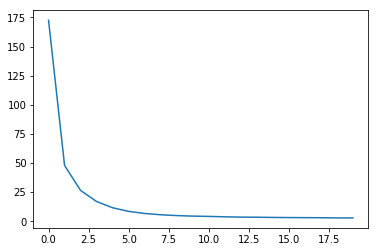

In [10]:
costs = []
n_batches = len(Ytrain) // batch_size
for i in range(epochs):
    n_total = 0
    n_correct = 0
    
    t0 = datetime.now()
    Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
    cost = 0
    
    for j in range(n_batches):
        x = Xtrain[j*batch_size:(j+1)*batch_size]
        y = Ytrain[j*batch_size:(j+1)*batch_size]
        
        c, p, _ = sess.run(
            (cost_op, predict_op, train_op),
            feed_dict = {inputs:x, targets:y}
        )
        cost += c
        
        # calculate the accuracy
        for yi, pi in zip(y, p): # p: NxT, y:NxT
            # we don't care about the padded entries so ignore them
            yii = yi[yi > 0]
            pii = pi[yi > 0]
            n_correct += np.sum(yii == pii)
            n_total += len(yii)
        
        # print stuff out periodically
        if j % 10 == 0:
            sys.stdout.write(
                "j/N: %d/%d correct rate so far: %f, cost so far: %f\r" % 
                (j, n_batches, float(n_correct)/n_total, cost)
            )
            sys.stdout.flush()
        
    
    p = sess.run(predict_op, feed_dict = {inputs: Xtest, targets: Ytest})
    n_test_correct = 0 
    n_test_total = 0
    for yi, pi in zip(Ytest, p):
        yii = yi[yi > 0]
        pii = pi[yi > 0]
        n_test_correct += np.sum(yii == pii)
        n_test_total += len(yii)
    test_acc = float(n_test_correct) / n_test_total

    print(
      "i:", i, "cost:", "%.4f" % cost,
      "train acc:", "%.4f" % (float(n_correct)/n_total),
      "test acc:", "%.4f" % test_acc,
      "time for epoch:", (datetime.now() - t0)
    )
    
    costs.append(cost)

plt.plot(costs)
plt.show()